<a href="https://colab.research.google.com/github/Mohamed-Khalil67/Deep-Learning/blob/main/Atelier_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Project Deep learning


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 7.3 MB/s 
     |████████████████████████████████| 189 kB 57.0 MB/s 
     |████████████████████████████████| 1.2 MB 48.5 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 51 kB 298 kB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

##Environnement matériel et logiciel



In [35]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import tensorflow.keras.applications as ka

# Visualisaiton des données
from matplotlib import pyplot as plt

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11856109433959176621
xla_global_id: -1
]


In [6]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

CPU


## Prise en charge des données 
### Structure des données 
```
data_dir
└───subsample/
│   └───train/
│   │   └───cats/
│   │   │   │   cat.0.jpg
│   │   │   │   cat.1.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.0.jpg
│   │   │   │   dog.1.jpg
│   │   │   │   ...
│   └───test/
│   │   └───cats/
│   │   │   │   cat.1000.jpg
│   │   │   │   cat.1000.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.1000.jpg
│   │   │   │   dog.1000.jpg
│   │   │   │   ...
```

##Création d'un jeu d'apprentissage et de validation

In [7]:
data_dir = 'gdrive/MyDrive/kaggle/' # chemin d'accès aux données

N_train = 200 #2000
N_val = 80 #800

data_dir_sub = data_dir+'subsample_%d_Ntrain_%d_Nval' %(N_train, N_val)

##Illustration des données

PIL image : The module also provides a number of factory functions, including functions to load images from files, and to create new images. Examples : Open, rotate, and display an image (using the default viewer)


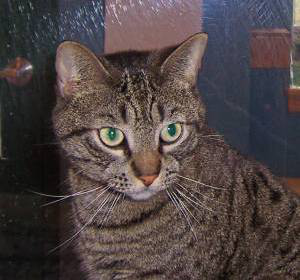

In [8]:
img = kpi.load_img(data_dir_sub+'/train/cats/cat.1.jpg')  # this is a PIL image
img

La fonction `img_to_array` génére un `array numpy` a partir d'une image PIL .

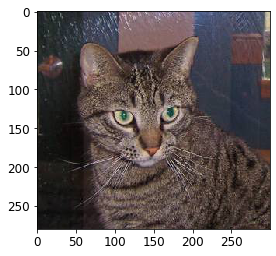

In [9]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

##Pré-traitements

on veut voire les shapes différents.

In [10]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.0.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg"))
x_0.shape, x_1.shape

((374, 500, 3), (280, 300, 3))

On utilise term réseau pour les couches de neurones afin de décriver les processings fait sur les inputs.

La fonction `ImageDataGenerator` de `Keras` permet de remèdier à ce problème.

Plus généralement cette fonction applique un certain nombre de traitements (transformation, normalisation) aléatoires sur les images de sorte que le modèle n'apprenne jamais deux fois la même image.

Quelques arguments de cette fonction:
* `rotation_range`: Un interval représentant les degrés possibles de rotation de l'image,
* `width_shift` and `height_shift`: intervales au sein desquels les données peuvent être translatées horizontalement ou verticalement, 
* `rescale`:  Une valeur par lequelle les données sont multipliées,
* `shear_range`:  Transvection,
* `zoom_range`: Permet des zoom au sein d'une image,
* `horizontal_flip`: Inverse aléatoirement des images selon l'axe horizontal,
* `fill_mode`: La strategie adoptée pour combler les pixels manquants après une transformation.

In [11]:
datagen = kpi.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

La commande `.flow()` genere de nouveaux exemples à partir de l'image originale et les sauve dans le dossier spécifié dans `save_to_dir`.

On force l'arrêt de cette génération après huits images générées.

In [12]:
img_width = 150
img_height = 150

img = kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg")  # this is a PIL image
x = kpi.img_to_array(img)  
x_ = x.reshape((1,) + x.shape)

if not(os.path.isdir(data_dir_sub+"/preprocessing_example")):
    os.mkdir(data_dir_sub+"/preprocessing_example")

    i = 0
    for batch in datagen.flow(x_, batch_size=1,save_to_dir=data_dir_sub+"/preprocessing_example", save_prefix='cat', save_format='jpeg'):
        i += 1
        if i > 7:
            break  

Illustration des images transformées.

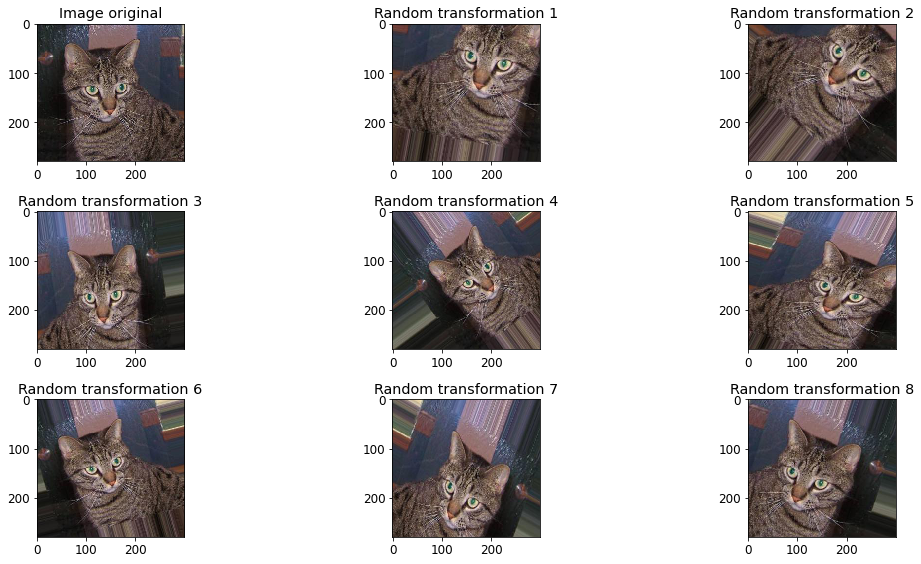

In [13]:
X_list=[]
for f in os.listdir(data_dir_sub+"/preprocessing_example"):
    X_list.append(kpi.img_to_array(kpi.load_img(data_dir_sub+"/preprocessing_example/"+f)))


fig=plt.figure(figsize=(16,8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3,3,1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i,xt in enumerate(X_list):
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" %(i+1))
plt.tight_layout()
plt.savefig("cats_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

## Classification d'image à l'aide du Deep Learning

Dans un premier temps, nous allons fixer le nombre d'epochs ainsi que la taille de notre batch afin que ces deux paramètres soit communs aux différentes méthodes que nous allons tester. 
Queques règles à suivre pour le choix de ces paramètres :

* `epochs`: Commencer avec un nombre d'epochs relativement faible (2,3) afin de voir le temps de calcul nécessaire à votre machine, puis augmenter le en conséquence.
* `batch_size`: La taille du batch correspond au nombre d'éléments qui seront étudié a chaque itération au cours d'une epochs. 


**Important** : Avec Keras, lorsque les données sont générés avec un générateur (voir précédemment) la taille du batch doit être un diviseur de la taille de l'échantillon. Sinon l'algorithme aura des comportement anormaux qui ne généreront pas forcément un message d'erreur.

In [14]:
epochs = 10
batch_size=20

### Réseau convolutionnel

Dans un premiers temps, on construit notre propre réseau de neurones convolutionnel.

#### Génération des données

On définit deux objets `ImageDataGenerator` :

* `train_datagen`: pour l'apprentissage, où différentes transformations sont appliquées, comme précédement
* `valid_datagen`: pour la validation, où l'on applique seulement une transformation *rescale* pour ne pas déformer les données.

Il est également important de définir la taille des images dans laquelle nos images seront reformatées. Ici nous choisirons un taille d'image de 150x150

In [15]:
# this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255,
)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir_sub+"/train/",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir_sub+"/validation/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 200 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


#### Définition du modèle

Le modèle est consitué de 3 blocs de convolution consitutés chacun de:

* Une couche de `Convolution2D`
* Une couche d'`Activation` ReLU
* Une couche `MaxPooling2D`

Suivi de :
* Une couche `Flatten`, permettant de convertir les features de 2 à 1 dimensions. 
* Une couche `Dense` (Fully connected layer)
* Une couche d' `Activation` ReLU
* Une couche `Dropout`
* Une couche `Dense` de taille 1 suivi d'une `Activation` sigmoid permettant la classification binaire

On utilise la fonction de perte `binary_crossentropy` pour apprendre notre modèle

In [16]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(1))
model_conv.add(kl.Activation('sigmoid'))

model_conv.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

##Apprentissage

In [17]:
ts = time.time()
model_conv.fit_generator(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs,
       validation_data=validation_generator,validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning TIme for %d epochs : %d seconds"%(epochs,t_learning_conv_simple_model))
model_conv.save(data_dir_sub+'/'+MODE+'_models_convolutional_network_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
10/10 [==============================] - 85s 9s/step - loss: 0.8767 - accuracy: 0.5400 - val_loss: 0.6846 - val_accuracy: 0.6000
Epoch 2/10
10/10 [==============================] - 6s 624ms/step - loss: 0.7135 - accuracy: 0.5450 - val_loss: 0.6878 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 6s 627ms/step - loss: 0.6883 - accuracy: 0.5650 - val_loss: 0.6840 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 6s 623ms/step - loss: 0.6786 - accuracy: 0.5700 - val_loss: 0.6831 - val_accuracy: 0.5375
Epoch 5/10
10/10 [==============================] - 6s 623ms/step - loss: 0.6770 - accuracy: 0.6450 - val_loss: 0.6925 - val_accuracy: 0.5500
Epoch 6/10
10/10 [==============================] - 6s 621ms/step - loss: 0.6359 - accuracy: 0.6750 - val_loss: 0.6827 - val_accuracy: 0.5750
Epoch 7/10
10/10 [==============================] - 6s 622ms/step - loss: 0.6372 - accuracy: 0.6950 - val_loss: 0.6903 - val_accuracy: 0.6000
Epoch 8/

##Prédiction

In [18]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val /batch_size, verbose=1)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train / batch_size, verbose=1)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


4/4 [==============================] - 1s 166ms/step - loss: 0.7284 - accuracy: 0.6625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


10/10 [==============================] - 2s 186ms/step - loss: 0.3834 - accuracy: 0.9300
Train accuracy: 0.9300000071525574
Validation accuracy: 0.6625000238418579
Time Prediction: 3.60 seconds


### Réseau pré-entrainé : VGG16

Nous allons voir dans cette partie deux façon d'utiliser un modèle pré-entrainé:

1. Dans un premier temps on utilise le modèle pour extraire des features des images qui seront utilisés dans un réseaux de convolution "classique". Ces features sont le résultats des transformations des différents blocs de convolution sur nos images.  
2. Dans un second temps on branchera le modèle "classique" généré  directement sur le modèle pré-entrainé. Ce modèle sera ensuite ré-entraîné plus finement (Fine Tuning) sur le dernier bloc de convolution.


#### Illustration du réseau

![](https://blog.keras.io/img/imgclf/vgg16_original.png)

##### Téléchargement des poids du modèle

Si cest la première fois que vous appeler l'application `VGG16`, le lancement des poids commencera automatiquement et seront stocké dans votre home : `"~/.keras/models"`

On utilise le modèle avec l'option `ìnclude_top` = False. C'est à dire que l'on ne télécharge pas le dernier bloc `Fully connected` classifier. 

La fonction `summary` permet de retrouver la structure décrite précédemment.

In [36]:
model_VGG16_without_top = ka.VGG16(weights='imagenet',include_top=False)
model_VGG16_without_top.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

##### Création des caractéristiques

On applique alors les 5 blocs du modèle VGG16 sur les images de nos échantillons d'apprentissage et de validation.

Cette opération peut-être couteuse, c'est pourquoi on va sauver ces features dans des fichiers afin d'effectuer qu'une fois cette opération.
Si ces fichiers existent, les poids seront téléchargés, sinon il seront créés.

In [37]:
features_train_path = data_dir_sub+'/features_train.npy' 
features_validation_path = data_dir_sub+'/features_validation.npy' 

if os.path.isfile(features_train_path) and os.path.isfile(features_validation_path):
    print("Load Features")
    features_train = np.load(open(features_train_path, "rb"))
    features_validation = np.load(open(features_validation_path, "rb"))
    
else:
    print("Generate Features")
    datagen = kpi.ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
            data_dir_sub+"/train",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,  # this means our generator will only yield batches of data, no labels
            shuffle=False)  
    features_train = model_VGG16_without_top.predict_generator(generator, N_train / batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_train_path, 'wb'), features_train)

    
    generator = datagen.flow_from_directory(
        data_dir_sub+"/validation",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
    features_validation = model_VGG16_without_top.predict_generator(generator, N_val / batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_validation_path, 'wb'), features_validation)
    

Generate Features
Found 200 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


10/10 [==============================] - 39s 4s/step
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


4/4 [==============================] - 16s 4s/step
